In [5]:
#A ne lancer que si vous n'avez pas les packages nécéssaires
"""
import sys
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError as e:
        print(f'package {e.name} non trouvé, installation en cours')
        pip.main(['install', '--user', package])  
        print(f'package {e.name} installé')

pkg_dependencies_list = [
    'matplotlib', 
    'scipy', 
    'numpy', 
    'tensorflow', 
    'pandas', 
    'sklearn'
]

for pkg in pkg_dependencies_list:
    import_or_install(pkg)
"""

"\nimport sys\nimport pip\n\ndef import_or_install(package):\n    try:\n        __import__(package)\n    except ImportError as e:\n        print(f'package {e.name} non trouvé, installation en cours')\n        pip.main(['install', '--user', package])  \n        print(f'package {e.name} installé')\n\npkg_dependencies_list = [\n    'matplotlib', \n    'scipy', \n    'numpy', \n    'tensorflow', \n    'pandas', \n    'sklearn'\n]\n\nfor pkg in pkg_dependencies_list:\n    import_or_install(pkg)\n"

# Introduction

Dans ce notebook, nous allons vous présenter deux modèles très simples de prédiction de séries temporelles à savoir les LSTM et les Forêts aléatoires. <br>
Ces deux modèles seront appliqués à la prédiction de la consommation energétique de GreEn-ER entre le 01/01/2020 et le 23/01/2022.


# Partie 1 : Préparation des données

Avant de commencer à faire les prédictions, il est important de connaître un minimum les données avec lesquelles on travaille et de vérifier si elles ne contiennent aucunes anomalies. Pour ce faire, on peut commencer par les afficher.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
%matplotlib inline

<AxesSubplot:xlabel='Date'>

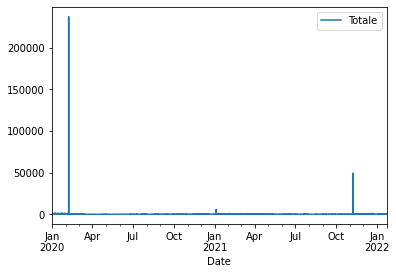

In [7]:
#chargement du dataset en utilisant la colonne 'Date' comme index
dataset = pd.read_csv("conso.csv", index_col='Date', parse_dates=['Date'])
dataset.plot()

On remarque la présence de valeurs extrêmes, on décide les supprimer. 
<br>
Cependant, il n'est pas toujours nécessaire de les supprimer. En effet, il se peut qu'elles représentent un évenement (très) rare comme par exemple la mesure de vagues scélérates, une hausse significative de la température un jour en hiver, etc...  
Dans ce cas, elles sont cohérentes et doivent être gardées. Ici elles sont dues à des problèmes de mesure, elles ne sont donc pas cohérentes.

### 1 - Suppression des valeurs extrêmes

Il existe plusieurs façon de procéder, ici on utilise la Cote Z 

In [8]:
from scipy import stats

In [9]:
#on vient supprimer les valeurs extrèmes
def outlier(df):

    z_score = stats.zscore(df)
    filtered = (np.abs(z_score) < 2).all(axis = 1)
    new_df = df[filtered]

    return new_df

<AxesSubplot:xlabel='Date'>

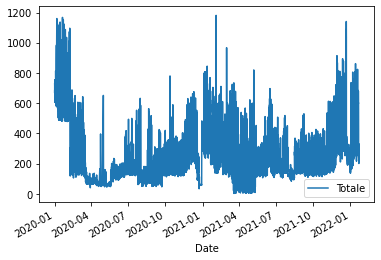

In [10]:
dataset = outlier(dataset)
dataset.plot()

### 2 - Normalisation des données

On normalise toutes les valeurs pour éviter les explosions du gradient

In [11]:
_min = dataset.min()
_max = dataset.max()

In [12]:
def scale(dataset, _min, _max):
    new_dataset = ((dataset - _min) / (_max - _min))
    return new_dataset

def unscale(dataset, _min, _max):
    new_dataset = dataset * (_max - _min) + _min
    return new_dataset

In [13]:
dataset_scaled = scale(dataset, _min, _max)

<AxesSubplot:xlabel='Date'>

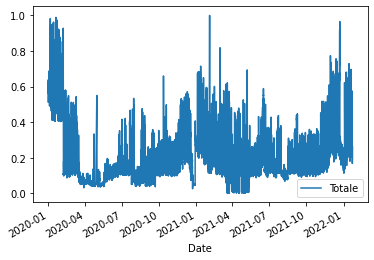

In [14]:
dataset_scaled.plot()

### 3 - Création des ensembles d'entrainement et de test

On va utiliser 95% du jeu de données pour l'entrainement des modèles et on va utiliser 11 heures pour prédire la 12ième.

In [15]:
size = int(len(dataset) * 0.95)

In [16]:
seq_len = 11

Une fois que le jeu de données est normalisé, on doit faire passer notre série temporelle en problème d'apprentissage supervisé.from keras.preprocessing.sequence import TimeseriesGenerator
Autrement dit, soit $X_{T} = \{x_{1}, \dots x_{t}\} = \{x_{i} : i \in T\}$ une série temporelle et soit $n \in \mathbb{N}$, on construit $\forall i \in [1, t-n]$, les vecteurs $S_{i} = (x_{i}, \dots, x_{i+n})$. On construit ensuite la matrice $M$ telle que la i-ième ligne de $M$ soit $S_{i}$.
<br><br>
Par exemple, soit $X_{T} = \{1, 2, 3, 4, 5, 6\}$, et $n=3$, on a les vecteurs $(1, 2, 3)$, $(2, 3, 4)$ et $(3, 4, 5)$ et $M=\begin{pmatrix} 1 & 2 & 3 \\ 2 & 3 & 4 \\ 3 & 4 & 5 \end{pmatrix}$. 
<br><br>
Pour les valeurs à prédire, c'est simple, il suffit de prendre $n+1$-ième valeurs pour chaque ligne, pour notre matrice $M$, on a $(1, 2, 3) -> 4$, $(2, 3, 4) -> 5$ et $(3, 4, 5) -> 6$, les valeurs à prédires sont alors $(4, 5, 6)$.
<br>
La fonction de Keras suivante réalise cette opération : TimeseriesGenerator

### Exemple :

In [17]:
array = np.array([1, 2, 3, 4, 5, 6])

In [18]:
trainGenerator = TimeseriesGenerator(array, array, length=3)

In [19]:
trainGenerator[0]

(array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]]),
 array([4, 5, 6]))

On retrouve bien le problème d'apprentissage supervisé de l'explication.

# Partie 2 :  Prédiction

## Prédiction : LSTM

On crée un premier generateur, celui d'entrainement en utilisant 95% du jeu de données et un second, celui de test en utilisant les 5% restant

In [20]:
trainGenerator = TimeseriesGenerator(dataset_scaled[:size].to_numpy(), dataset_scaled[:size].to_numpy(), length=seq_len)
testGenerator = TimeseriesGenerator(dataset_scaled[size:].to_numpy(), dataset_scaled[size:].to_numpy(), length=seq_len)

On définit une fonction retournant un réseau récurrent à base de LSTM très simple. <br>
Explications : <br>
    1. `model = Sequential()` -> Définition d'une pile de couches<br>
    2. `model.add(InputLayer(input_shape=(seq_len, 1)))` -> On ajoute à la pile une couche d'entrée prenant des entrées de dimension (11, 1), i.e la dimension d'un élement de TimeseriesGenerator<br>
    3. `model.add(LSTM(units=100))` -> On ajoute une couche de 100 cellules LSTM<br>
    4. `model.add(Dense(units=1))` -> On ajoute une couche de sortie d'un seul neurone<br>
    5. `model.compile(optimizer='rmsprop', loss='mse')` -> compilation du modèle avec une accélérateur de convergence 'rmsprop' propre au réseaux récurrents et une fonction de coût 'mse' pour mean squared error

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer

In [22]:
def createSimpleLSTM():
    model = Sequential()
    model.add(InputLayer(input_shape=(seq_len, 1)))
    model.add(LSTM(units=100))
    model.add(Dense(units=1))
    model.compile(optimizer='rmsprop', loss='mse')
    
    return model

on crée notre réseau et on l'entraîne

In [23]:
model = createSimpleLSTM()
model.fit(trainGenerator, epochs=10, batch_size=128)

Epoch 1/10
134/134 [==============================] - 3s 9ms/step - loss: 0.0057
Epoch 2/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0033
Epoch 3/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 4/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0023
Epoch 5/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 6/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 7/10
134/134 [==============================] - 1s 10ms/step - loss: 0.0021
Epoch 8/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 9/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0021
Epoch 10/10
134/134 [==============================] - 1s 9ms/step - loss: 0.0021


on fait une prédiction sur le jeu de données test

In [24]:
prediction = model.predict(testGenerator)

In [25]:
fig = plt.figure(figsize=(15, 7), dpi=100)
plt.plot(prediction, lw=0.7, label='prediction')
'''
Comme la taille de la séquence est 11, la première valeur prédite par le modèle est la 12-ième, il faut donc enlever les 11 premières valeurs du jeu de test.
Ce phénomène est propre à l'entrainement des modèles de Keras avec un TimeseriesGenerator
'''
plt.plot(dataset_scaled[size:].to_numpy()[11:], lw=0.7, label='real')
plt.legend()

On évalue les performances de notre modèle à l'aide de la function RMSE entre notre prédiction et le jeu de données test : 

In [26]:
np.sqrt(mean_squared_error(prediction, dataset_scaled[size:].to_numpy()[11:]))

0.049625255763587346

Plus la RMSE est proche de 0, plus notre prédiction est bonne, notre modèle est bon.

## Prédiction : RandomForestRegressor

Les modèles de sklearn ne fonctionnent pas avec le TimeseriesGenerator de Keras, la fonction suivante réalise la même opération

In [27]:
def create_dataset(dataset, seq_len):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_len-1):
        a = dataset[i:(i + seq_len), 0]
        dataX.append(a)
        dataY.append(dataset[i + seq_len, 0])
    return np.array(dataX), np.array(dataY)

In [28]:
dataX, dataY = create_dataset(dataset_scaled[:size].to_numpy(), seq_len)
testX, testY = create_dataset(dataset_scaled[size:].to_numpy(), seq_len)

On initialise une forêt aléatoire de 5 arbres de profondeur maximale 4. Il est très important de limiter la profondeur des arbres car la mémoire utilisée croît exponentiellement en la profondeur. 

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
model = RandomForestRegressor(n_estimators=5, max_depth=4)

In [31]:
model.fit(dataX, dataY)

RandomForestRegressor(max_depth=4, n_estimators=5)

In [32]:
prediction = model.predict(testX)

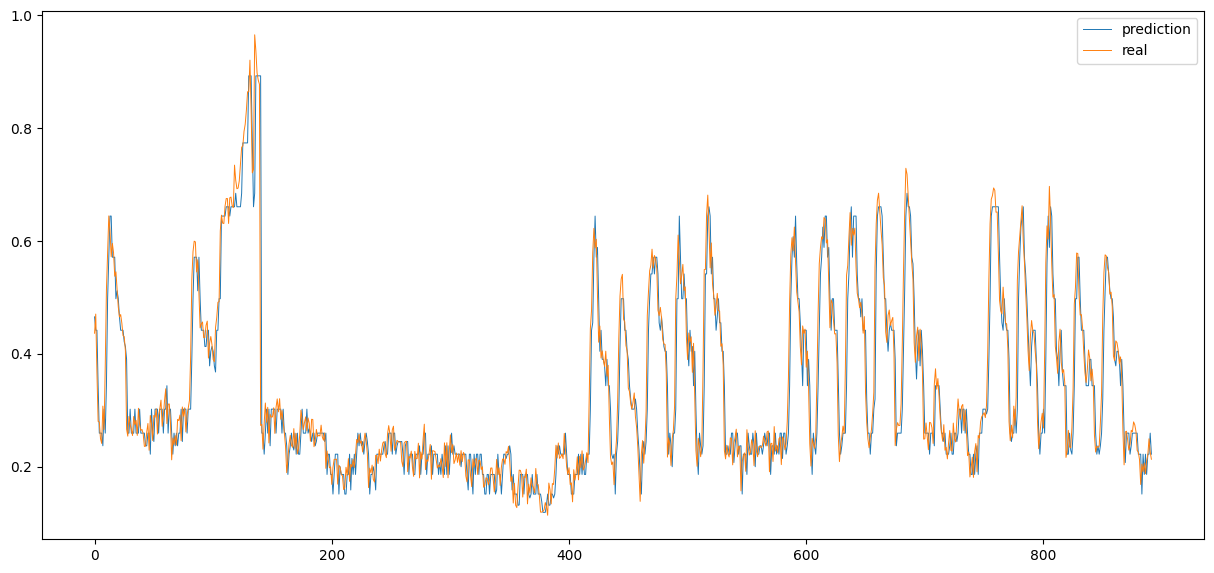

In [33]:
fig = plt.figure(figsize=(15, 7), dpi=100)
plt.plot(prediction, lw=0.7, label='prediction')
plt.plot(testY, lw=0.7, label='real')
plt.legend()

In [34]:
np.sqrt(mean_squared_error(prediction, testY))

0.052078258534077174

On remarque que la RMSE est plus grande qu'avec les LSTM et c'est normal, les forêts aléatoires donnent des résultats moins fins que les LSTM mais ont l'avantage de s'entrainer plus vite.

# Conclusion

Dans ce notebook, on aura vu les principes de bases du deep learning pour la prédiction de séries temporelles. On aura vu comment traiter un minimum les données, comment préparer les jeux de données d'entraînement et de test en fonction du modèle. Enfin, on aura vu comment déclarer à réseau récurent de type LSTM à l'aide de Keras, une forêt aléatoire à l'aide de Scikit-Learn et comment les entraîner afin de réaliser des prédictions.